In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Load the shipment data
shipments_df = pd.read_csv(
    "https://raw.githubusercontent.com/flyaflya/persuasive/main/shipments.csv", 
    parse_dates=['plannedShipDate', 'actualShipDate']
)

# Load product line data
product_line_df = pd.read_csv(
    "https://raw.githubusercontent.com/flyaflya/persuasive/main/productLine.csv"
)

# Reduce dataset size for faster processing (4,000 rows instead of 96,805 rows)
shipments_df = shipments_df.head(4000)

print("Shipments data shape:", shipments_df.shape)
print("\nShipments data columns:", shipments_df.columns.tolist())
print("\nFirst few rows of shipments data:")
print(shipments_df.head(10))

print("\n" + "="*50)
print("Product line data shape:", product_line_df.shape)
print("\nProduct line data columns:", product_line_df.columns.tolist())
print("\nFirst few rows of product line data:")
print(product_line_df.head(10))

Shipments data shape: (4000, 5)

Shipments data columns: ['shipID', 'plannedShipDate', 'actualShipDate', 'partID', 'quantity']

First few rows of shipments data:
   shipID plannedShipDate actualShipDate       partID  quantity
0   10001      2013-11-06     2013-10-04  part92b16c5         6
1   10002      2013-10-15     2013-10-04   part66983b         2
2   10003      2013-10-25     2013-10-07  part8e36f25         1
3   10004      2013-10-14     2013-10-08  part30f5de0         1
4   10005      2013-10-14     2013-10-08  part9d64d35         6
5   10006      2013-10-14     2013-10-08  part6cd6167        15
6   10007      2013-10-14     2013-10-08  parta4d5fd1         2
7   10008      2013-10-14     2013-10-08  part08cadf5         1
8   10009      2013-10-14     2013-10-08  part5cc4989        10
9   10010      2013-10-14     2013-10-08  part912ae4c         1

Product line data shape: (11997, 3)

Product line data columns: ['partID', 'productLine', 'prodCategory']

First few rows of product 

In [10]:
# This code has an error - can you spot it?
shipments_with_lateness = (
    shipments_df
    .assign(
    is_late=lambda df: df['actualShipDate'] > df['plannedShipDate'],
    days_late=lambda df: (df['actualShipDate'] - df['plannedShipDate']).dt.days,
    lateStatement=lambda df: np.where(df['is_late'],
                                    "Darn Shipment is Late",
                                    "Shipment is on Time")
)
)

In [11]:
# Query rows for late shipments and filter to keep specific columns
late_shipments = (
    shipments_with_lateness
    .query('is_late == True')  # Query rows where is_late is True
    .filter(['shipID', 'partID', 'plannedShipDate', 'actualShipDate', 'days_late'])  # Filter to keep specific columns
)

print(f"Found {len(late_shipments)} late shipments out of {len(shipments_with_lateness)} total")
print("\nLate shipments sample:")
print(late_shipments.head())

Found 456 late shipments out of 4000 total

Late shipments sample:
     shipID       partID plannedShipDate actualShipDate  days_late
776   10192  part0164a70      2013-10-09     2013-10-14          5
777   10192  part9259836      2013-10-09     2013-10-14          5
778   10192  part4526c73      2013-10-09     2013-10-14          5
779   10192  partbb47e81      2013-10-09     2013-10-14          5
780   10192  part008482f      2013-10-09     2013-10-14          5


In [12]:
# Create a cleaner dataset by dropping unnecessary columns
clean_shipments = (
    shipments_with_lateness
    .drop(columns=['quantity'])  # Drop quantity column (not needed for our analysis)
    .dropna(subset=['plannedShipDate', 'actualShipDate'])  # Remove rows with missing dates
)

print(f"Cleaned dataset: {len(clean_shipments)} rows, {len(clean_shipments.columns)} columns")
print("Remaining columns:", clean_shipments.columns.tolist())

Cleaned dataset: 4000 rows, 7 columns
Remaining columns: ['shipID', 'plannedShipDate', 'actualShipDate', 'partID', 'is_late', 'days_late', 'lateStatement']


In [13]:
# Sort by days late (worst first)
sorted_by_lateness = (
    clean_shipments
    .sort_values('days_late', ascending=False)  # Sort by days_late, highest first
    .reset_index(drop=True)  # Reset index to be sequential
)

print("Shipments sorted by lateness (worst first):")
print(sorted_by_lateness[['shipID', 'partID', 'days_late', 'is_late']].head(10))

Shipments sorted by lateness (worst first):
   shipID       partID  days_late  is_late
0   10956  partc63f9bc         21     True
1   10956  part3017fa1         21     True
2   10956  part1fedfcf         21     True
3   10956  parte820e31         21     True
4   10956  partb6208b5         21     True
5   10956  partc979912         21     True
6   10956  partc653823         21     True
7   10956  partb722d53         21     True
8   10956  part4875f85         21     True
9   10956  part04ef2f7         21     True


In [14]:
# Calculate overall service level metrics
service_metrics = (
    clean_shipments
    .agg({
        'is_late': ['count', 'sum', 'mean'],  # Count total, count late, calculate percentage
        'days_late': ['mean', 'max']  # Average and maximum days late
    })
    .round(3)
)

print("Overall Service Level Metrics:")
print(service_metrics)

# Calculate percentage on-time directly from the data
on_time_rate = (1 - clean_shipments['is_late'].mean()) * 100
print(f"\nOn-time delivery rate: {on_time_rate:.1f}%")

Overall Service Level Metrics:
        is_late  days_late
count  4000.000        NaN
sum     456.000        NaN
mean      0.114     -0.974
max         NaN     21.000

On-time delivery rate: 88.6%


In [15]:
# Merge shipment data with product line data
shipments_with_category = (
    clean_shipments
    .merge(product_line_df, on='partID', how='left')  # Left join to keep all shipments
    .assign(
        category_late=lambda df: df['is_late'] & df['prodCategory'].notna()  # Only count as late if we have category info
    )
)

print("\nProduct categories available:")
print(shipments_with_category['prodCategory'].value_counts())


Product categories available:
prodCategory
Marketables    1850
Machines        846
SpareParts      767
Liquids         537
Name: count, dtype: int64


In [16]:
# Analyze service levels by product category
service_by_category = (
    shipments_with_category
    .groupby('prodCategory')  # Split by product category
    .agg({
        'is_late': ['any', 'count', 'sum', 'mean'],  # Count, late count, percentage late
        'days_late': ['mean', 'max']  # Average and max days late
    })
    .round(3)
)

print("Service Level by Product Category:")
print(service_by_category)

Service Level by Product Category:
             is_late                   days_late    
                 any count  sum   mean      mean max
prodCategory                                        
Liquids         True   537   22  0.041    -0.950  19
Machines        True   846  152  0.180    -1.336  21
Marketables     True  1850  145  0.078    -0.804  21
SpareParts      True   767  137  0.179    -1.003  21


In [17]:
# Create a comprehensive analysis dataset
comprehensive_analysis = (
    shipments_with_category
    .groupby(['shipID', 'prodCategory'])  # Group by shipment and category
    .agg({
        'is_late': 'any',  # True if any item in this shipment/category is late
        'days_late': 'max'  # Maximum days late for this shipment/category
    })
    .reset_index()
    .assign(
        has_multiple_categories=lambda df: df.groupby('shipID')['prodCategory'].transform('nunique') > 1
    )
)

print("Comprehensive analysis - shipments with multiple categories:")
multi_category_shipments = comprehensive_analysis[comprehensive_analysis['has_multiple_categories']]
print(f"Shipments with multiple categories: {multi_category_shipments['shipID'].nunique()}")
print(f"Total unique shipments: {comprehensive_analysis['shipID'].nunique()}")
print(f"Percentage with multiple categories: {multi_category_shipments['shipID'].nunique() / comprehensive_analysis['shipID'].nunique() * 100:.1f}%")

Comprehensive analysis - shipments with multiple categories:
Shipments with multiple categories: 232
Total unique shipments: 997
Percentage with multiple categories: 23.3%


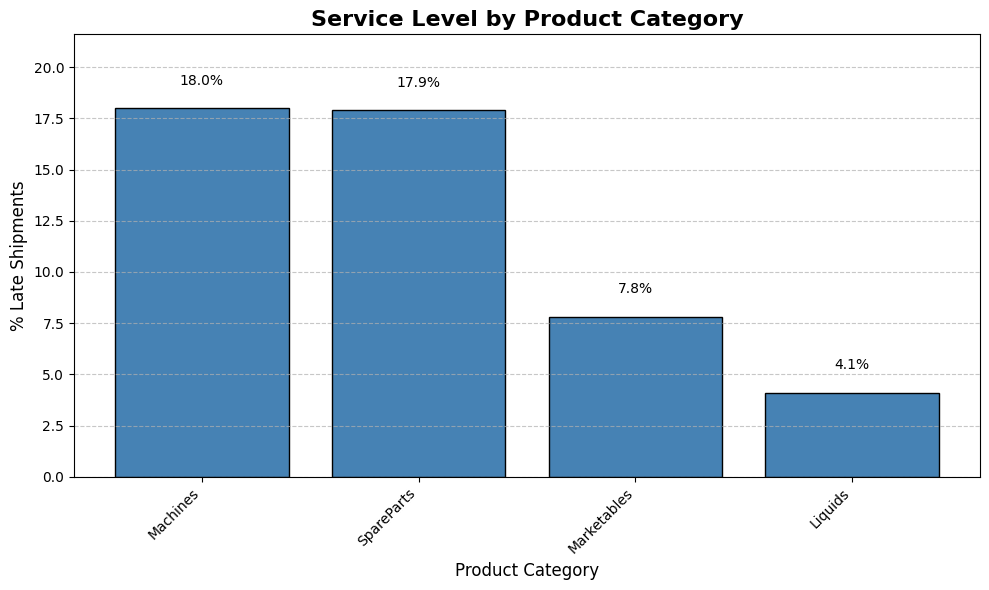

In [19]:
import matplotlib.pyplot as plt

# Sample data: replace with your actual DataFrame
# Assuming service_by_category is a MultiIndex DataFrame from your groupby/agg
# and 'is_late', 'mean' gives the % late per category
service_level = service_by_category['is_late']['mean'] * 100  # Convert to percentage

# Sort for better visual impact
service_level = service_level.sort_values(ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(service_level.index, service_level.values, color='steelblue', edgecolor='black')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# Styling
ax.set_title('Service Level by Product Category', fontsize=16, fontweight='bold')
ax.set_ylabel('% Late Shipments', fontsize=12)
ax.set_xlabel('Product Category', fontsize=12)
ax.set_ylim(0, max(service_level.values) * 1.2)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
